# Healthcare Final Project (Fall 2023): Prediction and Data Visualization of Sepsis
### Yihan Li (yl10798) Yantao Luo (yl5929)

In [1]:
import pandas as pd
import seaborn as sns 
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, roc_auc_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats
from collections import Counter

## 1. Data Analysis and Preprocessing

In [2]:
sepsis_df = pd.read_csv('Dataset.csv')
sepsis_df = sepsis_df.drop(columns='Unnamed: 0')
sepsis_df.head()

,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,...,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,Patient_ID
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,1,0,17072
1,1,65.0,100.0,NaN,NaN,72.0,NaN,16.5,NaN,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,2,0,17072
2,2,78.0,100.0,NaN,NaN,42.5,NaN,NaN,NaN,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,3,0,17072
3,3,73.0,100.0,NaN,NaN,NaN,NaN,17.0,NaN,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,4,0,17072
4,4,70.0,100.0,NaN,129.0,74.0,69.0,14.0,NaN,NaN,...,NaN,330.0,68.54,0,NaN,NaN,-0.02,5,0,17072


In [3]:
# Drop Administrative Data
columns_to_drop = ['Unit1', 'Unit2', 'HospAdmTime', 'ICULOS']
sepsis_df = sepsis_df.drop(columns=columns_to_drop)

### 1.1 Data Inspection

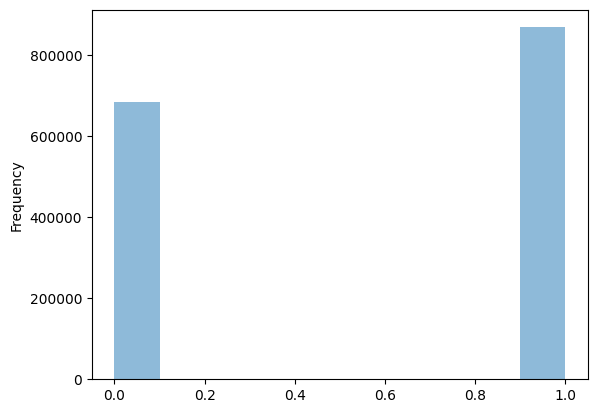

In [4]:
sepsis_df.Gender.plot.hist(alpha=0.5);

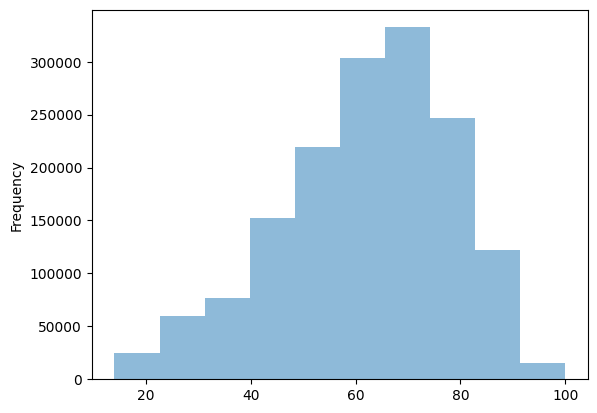

In [5]:
sepsis_df.Age.plot.hist(alpha=0.5);

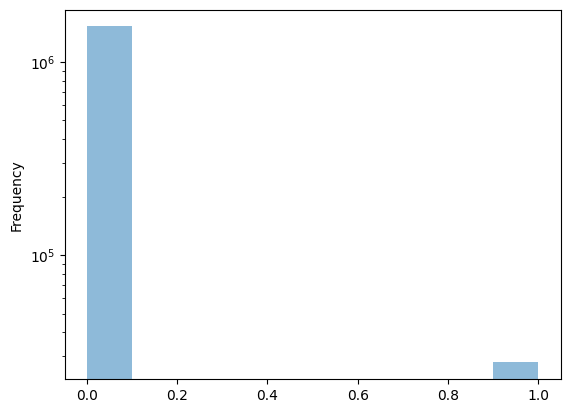

In [6]:
sepsis_df.SepsisLabel.plot.hist(alpha=0.5, logy=True);

### 1.2 Data Imputation

In [7]:
grouped_by_patient = sepsis_df.groupby('Patient_ID')
sepsis_df = grouped_by_patient.apply(lambda x: x.bfill().ffill())
sepsis_df.head()

Hour     HR  O2Sat   Temp    SBP    MAP  DBP  Resp  EtCO2  \
Patient_ID                                                                     
1          132940     0   97.0   95.0  36.11   98.0  75.33  NaN  19.0    NaN   
           132941     1   97.0   95.0  36.11   98.0  75.33  NaN  19.0    NaN   
           132942     2   89.0   99.0  36.11  122.0  86.00  NaN  22.0    NaN   
           132943     3   90.0   95.0  36.11  122.0  91.33  NaN  30.0    NaN   
           132944     4  103.0   88.5  36.11  122.0  91.33  NaN  24.5    NaN   

                   BaseExcess  ...   Hct   Hgb  PTT  WBC  Fibrinogen  \
Patient_ID                     ...                                     
1          132940        24.0  ...  37.2  12.5  NaN  5.7         NaN   
           132941        24.0  ...  37.2  12.5  NaN  5.7         NaN   
           132942        24.0  ...  37.2  12.5  NaN  5.7         NaN   
           132943        24.0  ...  37.2  12.5  NaN  5.7         NaN   
           132944        23.0  ...  37.2  12.5  NaN  5.7         NaN   

                   Platelets    Age  Gender  SepsisLabel  Patient_ID  
Patient_ID                                                            
1          132940      317.0  83.14       0            0           1  
           132941      317.0  83.14       0            0           1  
           132942      317.0  83.14       0            0           1  
           132943      317.0  83.14       0            0           1  
           132944      317.0  83.14       0            0           1  

[5 rows x 39 columns]

In [8]:
nan_percentage = sepsis_df.isnull().mean() * 100
threshold = 50

# Get columns where the percentage of NaN values is greater than the threshold
high_nan_columns = nan_percentage[nan_percentage > threshold]
print("Columns with more than 50% NaN values:")
print(high_nan_columns)

Columns with more than 50% NaN values:
EtCO2               89.938861
BaseExcess          63.709743
FiO2                50.224390
SaO2                62.980589
AST                 59.567520
Alkalinephos        60.012756
Bilirubin_direct    93.266633
Lactate             63.533607
Bilirubin_total     59.799447
TroponinI           81.905412
Fibrinogen          86.219455
dtype: float64


### 1.3 Sampling Train Set and Test Set

In [9]:
# Split training set and test set
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(sepsis_df, test_size=0.3, train_size=0.7, random_state=1124, shuffle=True, stratify=None)
train_set.head()

,,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,...,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,Age,Gender,SepsisLabel,Patient_ID
Patient_ID,,,,,,,,,,,,,,,,,,,,,,
105154,1217087,25,85.0,99.0,35.50,158.0,104.00,72.0,48.0,NaN,NaN,...,31.0,9.0,NaN,5.6,NaN,154.0,100.00,1,0,105154
11246,111551,8,67.0,100.0,37.11,117.0,78.33,NaN,14.0,NaN,NaN,...,35.5,12.0,NaN,8.7,NaN,249.0,39.52,0,0,11246
15532,294296,30,65.0,95.0,36.67,104.0,75.00,NaN,18.0,NaN,NaN,...,34.5,12.2,35.5,5.4,305.0,138.0,75.67,1,0,15532
1577,443179,35,87.0,96.0,36.33,127.0,79.00,NaN,22.0,NaN,NaN,...,28.1,9.7,NaN,13.6,NaN,258.0,75.05,0,0,1577
6195,601778,3,120.0,95.0,37.61,90.0,65.33,NaN,24.0,NaN,NaN,...,30.3,10.4,31.7,0.7,NaN,23.0,73.30,0,0,6195


In [10]:
pos_set = train_set[train_set.SepsisLabel == 1]
neg_set = train_set[train_set.SepsisLabel == 0]
neg_set = neg_set.sample(frac = 0.1)
train_set = pd.concat([pos_set,neg_set])

y = train_set.SepsisLabel
X = train_set.drop(columns='SepsisLabel')

from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X, y)

print(sorted(Counter(y_resampled).items()))

[(0, 106704), (1, 106704)]


Adopt the following method after data imputation

In [11]:
# # need data without NaN
# from imblearn.combine import SMOTEENN
# smote_enn = SMOTEENN(random_state=0)
# X_resampled, y_resampled = smote_enn.fit_resample(X, y)
# print(sorted(Counter(y_resampled).items()))

### 1.4 Correlation Analysis

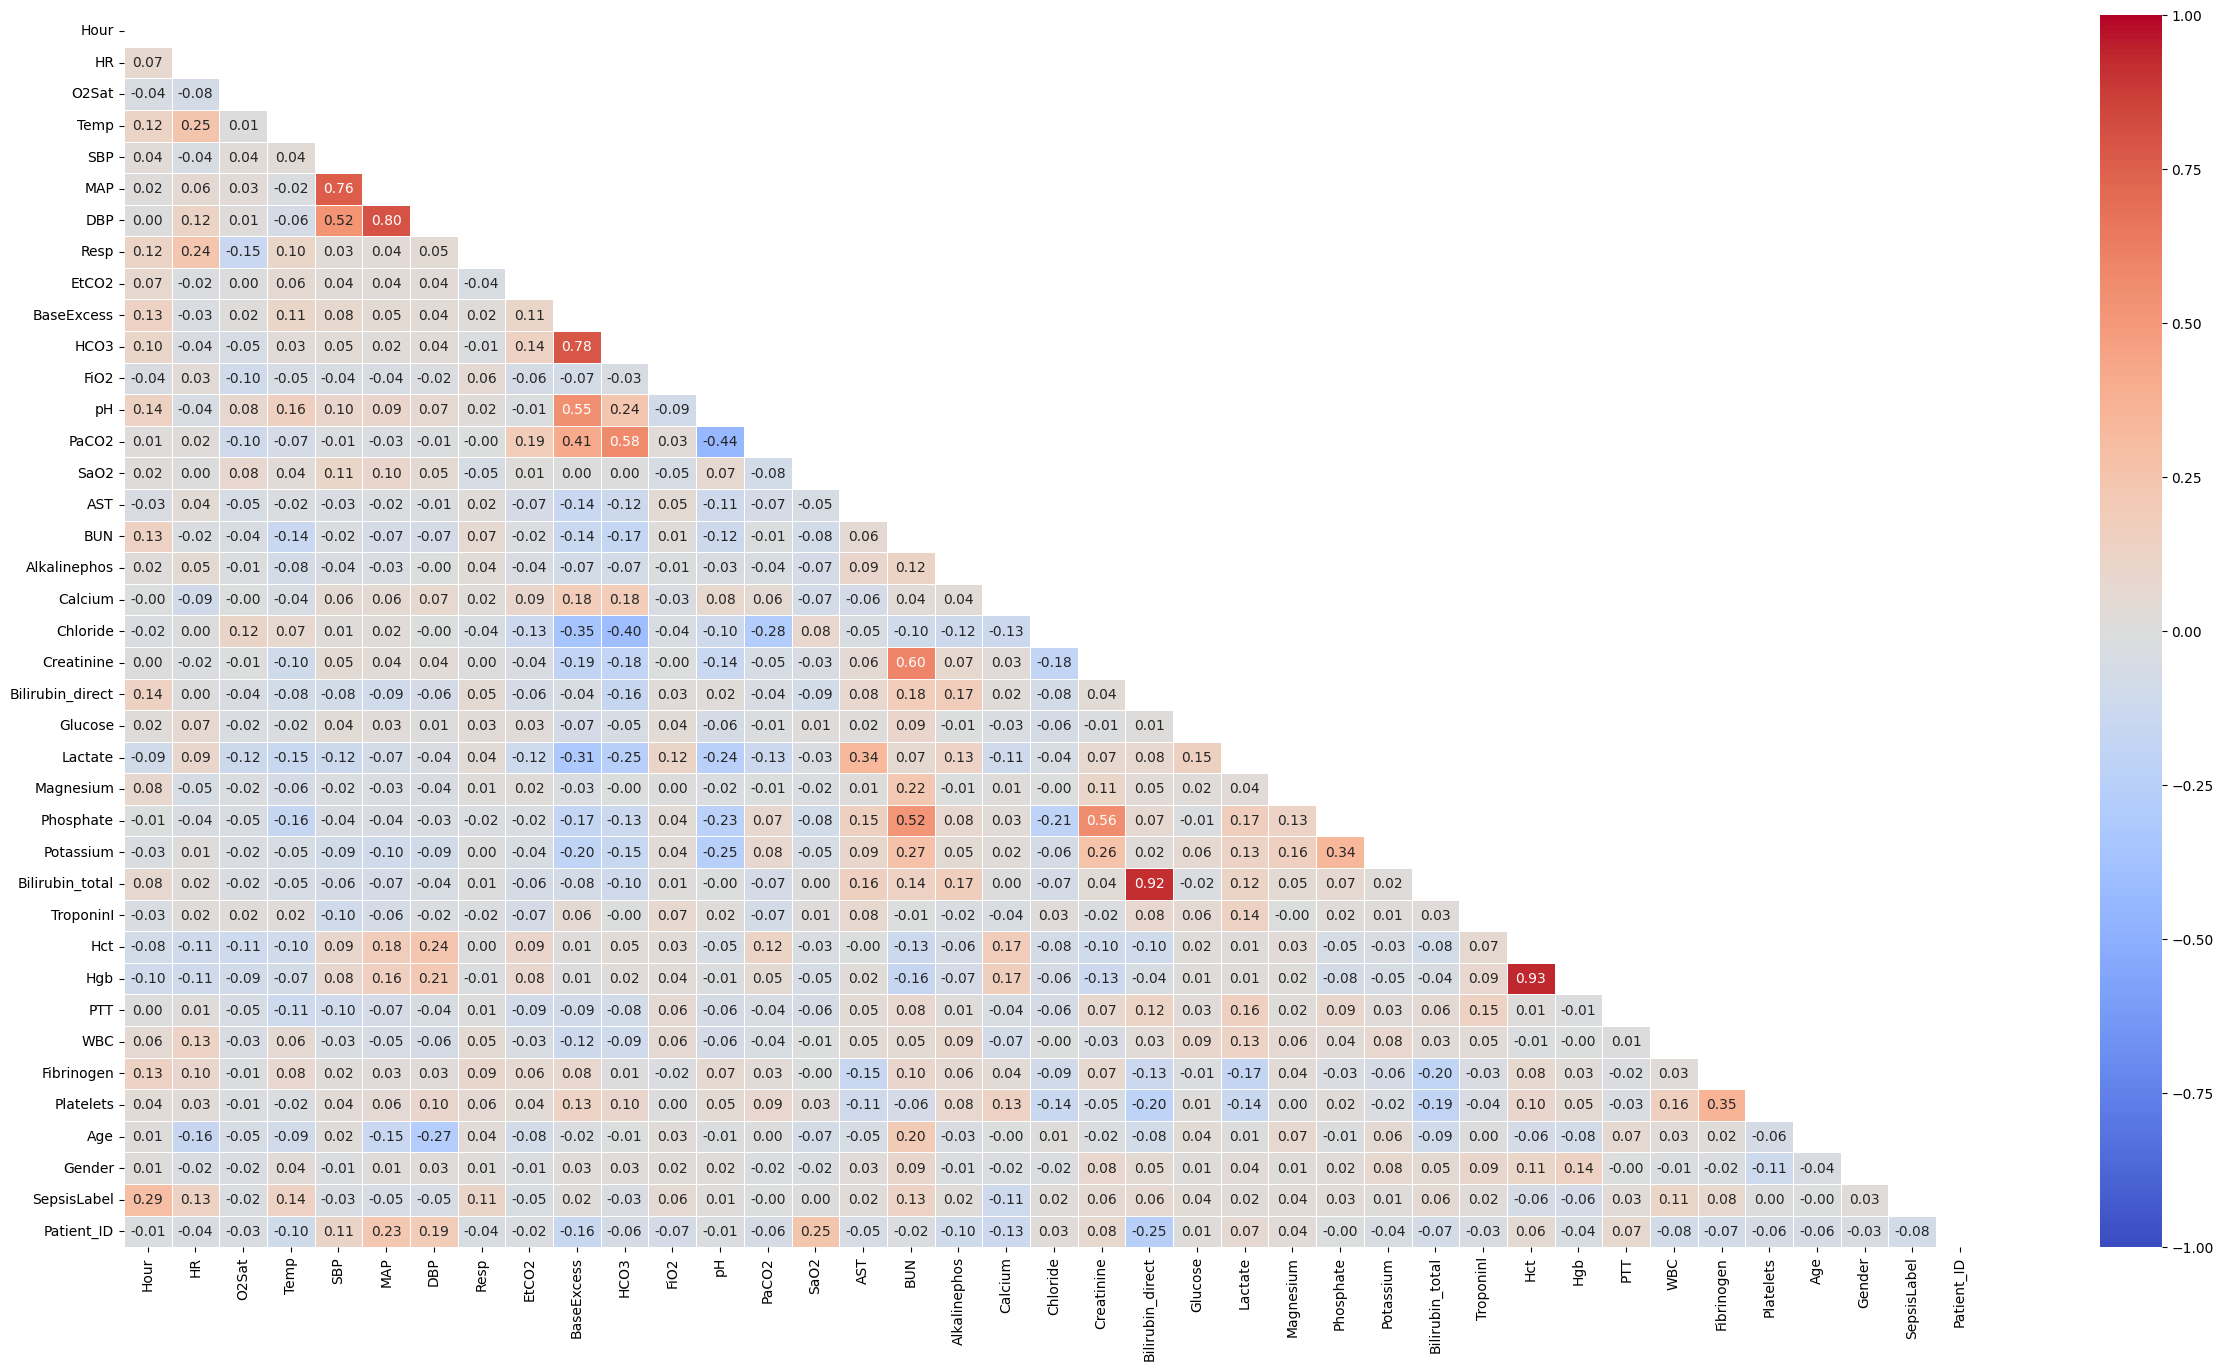

In [12]:
# correlation matrix to check the correlation between the remaining features
correlation_matrix = train_set.corr()
plt.figure(figsize=(30, 16))

# Create a heatmap using seaborn
sns.heatmap(correlation_matrix, 
            annot=True,       # Add correlation values to the squares
            mask = np.triu(np.ones_like(correlation_matrix, dtype=bool)),
            cmap='coolwarm',  # Color scheme
            vmin=-1, vmax=1,  # Set the scale for the color bar
            fmt='.2f',        # Formatting numbers
            linewidths=.5)    # Space between cells

plt.show()

In [13]:
columns = train_set.columns

# Create an empty DataFrame to store the p-values
p_values = pd.DataFrame(index=columns, columns=columns)

# Loop through the columns and calculate the p-values
for col in columns:
    # Calculate the Pearson correlation coefficient and the p-value
    corr_test = pearsonr(train_set['SepsisLabel'], train_set[col])
    # Assign the p-value to the correct position in the DataFrame
    p_values.loc['SepsisLabel', col] = corr_test[1]

# Convert all the p-value entries from objects to floats
p_values = p_values.astype(float)

NameError: name 'pearsonr' is not defined